In [175]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
import time

In [176]:
#Returns the product (A x B x C)u
def kron_eval(A, B, C, u):
    ma, na = A.shape
    mb, nb = B.shape
    mc, nc = C.shape

    v = np.zeros((nc, mb, na))
    u = u.reshape((nc, nb, na))

    Bt = B.transpose()

    for k in range(na):
        v[:, :, k] = u[:, :, k] @ Bt

    v = v.reshape((nc, nb*na))
    v = C @ (v)
    
    v = v.reshape((mc*nb, nc))
    v = v @ (A.transpose())
    
    v = v.reshape((ma*mb*mc, 1))
    return v

In [271]:
def fast_solve(Ax, f):
    lamda, Sx = np.linalg.eigh(Ax.toarray())
    lx=sp.diags(lamda)
    I=sp.identity(lx.shape[0])
    Sx_inv=np.transpose(Sx)
    vec=kron_eval(Sx_inv,Sx_inv,Sx_inv,f).T
    D=(sp.kron(sp.kron(I,I),lx)+sp.kron(sp.kron(I,lx),I)+sp.kron(sp.kron(lx,I),I)).diagonal()
    vc=np.divide(vec,D)
    f=kron_eval(Sx,Sx,Sx,vc)
    return f

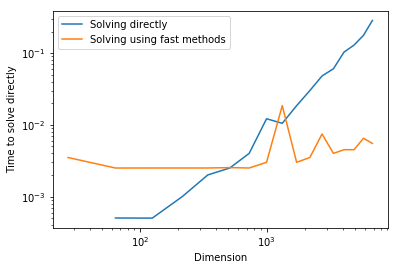

In [273]:
Nmax=20
Directsolve_time =[]
Fastsolve_time=[]
dim=[N**3 for N in range(3, Nmax)]
for N in range(3, Nmax):
    Ax=(N+1)**2*sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
    f=np.random.rand(N**3)
    I=sp.identity(N)
    A= sp.kron(sp.kron(I,I),Ax) + sp.kron(sp.kron(I,Ax),I)+ sp.kron(sp.kron(Ax,I),I)
    A=A.tocsc()
    start2 = time.time()
    x=la.spsolve(A,f)
    end2 = time.time()
    Directsolve_time.append(end2-start2)
    start1=time.time()
    sol=fast_solve(Ax, f)
    end1=time.time()
    Fastsolve_time.append(end1-start1)
plt.loglog(dim,Directsolve_time, label='Solving directly')
plt.loglog(dim,Fastsolve_time,label='Solving using fast methods')
plt.xlabel('Dimension')
plt.ylabel('Time to solve directly')
plt.legend()
plt.show()